In [1]:
import uproot
import h5py
import numpy as np
import awkward as ak
import vector
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from tqdm import tqdm

In [2]:
path = 'C:/Users/HP/Documents/data/' #edit this path to the data directory
filenames = ['4top_odd_Q99_02.root', '4top_even_Q99_02.root'] #list of file_names to be accessed
#filenames = ['4top_odd_Q99.root', '4top_even_Q99.root']

In [3]:
def create_4_vectors(tree, particle):
    # creates a 4 vector for a given particle form a given tree (i.e t_even 4 vector)
    # first finds the max length in case padding is needed. This isn't needed for this file, but included for completeness
    max_len = np.max(ak.num(tree[f'{particle}_pt'].array(), axis = 1))
    names = ['pt', 'eta', 'phi', 'e']
    array = []
    for name in names:
        values = tree[f'{particle}_{name}'].array()
        padded = ak.pad_none(values, max_len, axis=1)
        padded = ak.fill_none(padded, 0)
        array.append(padded)
    
    vector_array = []
    for i in range(max_len):
        vector_array.append(vector.zip({param:array[j][:,i] for j, param in enumerate(names)})) # each element in vector array is another top quark
    
    return vector_array


def construct_array(t_even, tbar_even):
    # finds differences of values for each pair of t tbar
    dic = {'rapidity':[], 'phi':[], 'R':[]}
    array = 0
    for i in range(2):
        for j in range(2):
            d_rapidity = t_even[i].rapidity - tbar_even[j].rapidity
            d_R =  t_even[i].deltaR(tbar_even[j])
            d_phi = t_even[i].deltaphi(tbar_even[j])
            dic['rapidity'].append(d_rapidity)
            dic['phi'].append(d_phi)
            dic['R'].append(d_R)
    return dic

def b2(vector1, vector2):
    numerator = vector1.py * vector2.py+ vector1.px * vector2.px
    return numerator/(vector1.p * vector2.p)

def b4(vector1, vector2):
    return vector1.pz*vector2.pz/(vector1.p * vector2.p)

def norm_p(vec):
    vec_p = np.array([vec.x, vec.y, vec.z])
    return vec_p / np.sqrt(np.sum(vec_p**2, axis=0))


In [9]:
def form_training_data(tree):
    # packages all the parameters into an h5 file
    # we can then select the parameters we want in the training program
    # save a seperate file for cp odd and cp even
    # note that all that have no label of tt or tbar tbar are ttbar



    #tree = base[f'CP_{even_odd}']
    t = create_4_vectors(tree, 't')
    tbar = create_4_vectors(tree, 'tbar')


    
    tt = t[0] + t[1] #for eta and invariant mass, rapidity
    tbartbar = tbar[0] + tbar[1] # for eta and invariant mass, rapidity
    tttt = tt + tbartbar
    ttbars = [t[0] + tbar[0],
                t[0] + tbar[1],
                t[1] + tbar[0],
                t[1] + tbar[1]
                ]
    # each combination of t and tbar
    
    dic = {}


    # # if not explicitly mentioned, the variable is for the ttbar system
    # # the order is the same as the images sent on whatsapp
    dic['Ht'] = t[0].pt + t[1].pt + tbar[0].pt + tbar[1].pt
    dic['tttt_m'] = tttt.m
    dic['tt_m'] = tt.m
    dic['tbartbar_m'] = tbartbar.m
    dic['greatest_mass']  = np.max([i.m for i in ttbars], axis = 0)

    dic['tt_eta'] = tt.eta
    dic['tbartbar_eta'] = tbartbar.eta
    dic['greatest_eta']  = np.max([i.eta for i in ttbars], axis = 0)
    dic['average_eta'] = np.mean([i.eta for i in ttbars], axis = 0)
    dic['min_eta'] = np.min([i.eta for i in ttbars], axis = 0)


    differences = construct_array(t, tbar)

    dic['tt_rapidity'] = np.abs(t[0].rapidity - t[1].rapidity)
    dic['tbartbar_rapidity'] = np.abs(tbar[0].rapidity - tbar[1].rapidity)
    dic['greatest_rapidity']  = np.max(differences['rapidity'], axis = 0)
    dic['average_rapidity'] = np.mean(differences['rapidity'], axis = 0)
    dic['min_rapidity'] = np.min(differences['rapidity'], axis = 0)

    dic['tt_phi'] = np.abs(t[0].phi - t[1].phi)
    dic['tbartbar_phi'] = np.abs(tbar[0].phi - tbar[1].phi)
    dic['greatest_phi']  = np.max(differences['phi'], axis = 0)
    dic['average_phi'] = np.mean(differences['phi'], axis = 0)
    dic['min_phi'] = np.min(differences['phi'], axis = 0)

    dic['tt_R'] = t[0].deltaR(t[1])
    dic['tbartbar_R'] = tbar[0].deltaR(tbar[1])
    dic['greatest_R']  = np.max(differences['R'], axis = 0)
    dic['average_R'] = np.mean(differences['R'], axis = 0)
    dic['min_R'] = np.min(differences['R'], axis = 0)
    dic['overall_min_R'] = np.min([dic['tt_R'], dic['tbartbar_R'], dic['min_R']], axis = 0)

    dic['tt_pt'] = tt.pt
    dic['tbartbar_pt'] = tbartbar.pt
    dic['greatest_pt']  = np.max([i.pt for i in ttbars], axis = 0)
    min_indices = np.argmin(differences['rapidity'], axis=0)
    dic['ttbar_pt_smallest_dR'] = ttbars[0].pt*(min_indices == 0) + ttbars[1].pt*(min_indices == 1) + ttbars[2].pt*(min_indices == 2) + ttbars[3].pt*(min_indices == 3)

    dic['overall_max_pt'] = np.max([i.pt for i in t + tbar], axis = 0)
    dic['overall_min_pt'] = np.min([i.pt for i in t + tbar], axis = 0)
    dic['overall_diff_pt'] = dic['overall_max_pt'] - dic['overall_min_pt']

    dic['tt_alignment'] = b2(t[0], t[1])
    dic['tbartbar_alignment'] = b2(tbar[0], tbar[1])
    b2s = np.stack((b2(t[0],tbar[0]), b2(t[0],tbar[1]), b2(t[1],tbar[0]), b2(t[1],tbar[1])), axis = 1)
    b4s = np.stack((b4(t[0],tbar[0]), b4(t[0],tbar[1]), b4(t[1],tbar[0]), b4(t[1],tbar[1])), axis = 1)
    max_ttbar_pt_index = np.argmax([i.pt for i in ttbars], axis = 0)

    stacking = np.stack([(max_ttbar_pt_index == i) for i in range(4)], axis = 1)
    dic['leading_pt_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_pt_b4'] = np.sum(stacking * b4s, axis = 1)

    max_t_pt_index = np.argmax([i.pt for i in t], axis = 0)
    max_t_pt_differences = differences['R'][0:2] * (max_t_pt_index == 0) + differences['R'][2:] * (max_t_pt_index == 1) # define closest as smallest delta R
    final_indicies = 2*max_t_pt_index+np.argmin(max_t_pt_differences, axis = 0)
    stacking = np.stack([(final_indicies == i) for i in range(4)], axis = 1)
    dic['leading_tpt_ttbar_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_tpt_ttbar_b4'] = np.sum(stacking * b4s, axis = 1)

    max_tbar_pt_index = np.argmax([i.pt for i in tbar], axis = 0)
    max_tbar_pt_differences = differences['R'][0::2] * (max_tbar_pt_index == 0) + differences['R'][1::2] * (max_tbar_pt_index == 1) # define closest as smallest delta R
    final_indicies = 2*np.argmin(max_tbar_pt_differences, axis = 0) + max_tbar_pt_index
    stacking = np.stack([(final_indicies == i) for i in range(4)], axis = 1)
    dic['leading_tbarpt_ttbar_b2'] = np.sum(stacking * b2s, axis = 1)
    dic['leading_tbarpt_ttbar_b4'] = np.sum(stacking * b4s, axis = 1)

    for i, pair1 in enumerate(ttbars):
        pair2_t = t[1- i//2].boostCM_of(pair1)
        pair2_t_p = norm_p(pair2_t)
        pair2_tbar = tbar[1-i%2].boostCM_of(pair1)
        pair2_tbar_p = norm_p(pair2_tbar)
        beam_axis = vector.obj(x=0, y=0, z=1, t=0).boost(pair1)
        beam_axis_p = norm_p(beam_axis)
        a = np.cross(pair2_t_p, pair2_tbar_p, axis=0)
        dic[f'boosted_cross_{i}x'] = a[0]
        dic[f'boosted_cross_{i}y'] = a[1]
        dic[f'boosted_cross_{i}z'] = a[2]
        dic[f'CS_angle_t{i}'] = np.einsum('ij,ij->i', pair2_tbar_p.T, beam_axis_p.T)
        dic[f'CS_angle_tbar{i}'] = np.einsum('ij,ij->i', pair2_t_p.T, beam_axis_p.T)
        



    # 31 in total inputs (should make it 32 and then its a nice round number)
    # is this too many? could begin with a smaller ammount and then add some

    # h5_file = h5py.File(path+f"new_tttt_{even_odd}.h5", 'w')
    # group = h5_file.create_group('Objects')
    # for key in dic.keys():
    #     group.create_dataset(key, data=dic[key])
    
    # h5_file.close()
    return dic

#need to check boosted cross - not quite right?

In [10]:
all_data = {}
for file in filenames:
    base = uproot.open(path+file)
    for key, value in base.items():
        if len(base.keys()) ==1:
            key = ''
        all_data[file.split('.root')[0]+key.split(';')[0]] = form_training_data(value)


# original = uproot.open(path+'4top_parton_CPstudy.root')
# all_data['original_even'] = form_training_data(original['CP_even'])
# all_data['original_odd'] = form_training_data(original['CP_even'])


In [11]:
def plot_variables(dics, bins = 50):
    variables = list(list(dics.values())[0].keys())
    hep.style.use(hep.style.ATLAS)  # Set the style once at the beginning
    
    # plots all the variables
    for variable in variables:
        all_values = np.concatenate([dic[variable] for dic in dics.values()])
        high_limit = np.max(all_values)*0.5
        low_limit = min(0, np.min(all_values))*0.5
        
        hists = []
        for name, dic in dics.items():
            hist = bh.Histogram(bh.axis.Regular(bins, low_limit, high_limit))
            hist.fill(dic[variable])
            hists.append(hist)
        
        plt.figure()  # Initialize a new figure for each plot
        hep.histplot([hist/hist.sum() for hist in hists], label=[name for name in dics.keys()])
        
        plt.xlabel(f'{variable}')  # You might want to customize this
        plt.ylabel('Normalized Frequency')
        plt.title(f'{variable} for odd and even')
        plt.legend()
        plt.show()

4topCPeven_no_az
p p > t t~ t t~ / a z x1 x2 QCD<=2 QED<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 1.000000e+00 # ca
    3 1.000000e+00 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt

4topCPodd_no_az
p p > t t~ t t~ / a z x1 x2 QCD<=2 QED<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 0.000001e+00 # ca
    3 1.000000e+06 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt

4topCPeven_ke6
p p > t t~ t t~ /x1 x2 QED<=2 QCD<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 1.000000e+00 # ca
    3 1.000000e+00 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt

4topCPodd_ke6
p p > t t~ t t~ /x1 x2 QED<=2 QCD<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 1.000000e-06 # ca
    3 1.000000e+06 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt


do bottom 2 
- always want QED=99 (set both as 99)



4top_even_Q99
p p > t t~ t t~ /x1 x2 QED<=99 QCD<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 1.000000e+00 # ca
    3 1.000000e+00 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt


4top_odd_Q99
p p > t t~ t t~ /x1 x2 QED<=99 QCD<=99 QNP=0
Block frblock
    1 1.000000e+03 # Lambda
    2 1.000000e-06 # ca
    3 1.000000e+06 # kSM
    4 1.000000e+00 # kHtt
    5 1.000000e+00 # kAtt



sum of cpu time of last step: 4h30m43s
INFO: finish refine
refine 100000 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events
  === Results Summary for run: run_01 tag: tag_1 ===

     Cross-section :   0.009865 +- 8.914e-06 pb
     Nb of events :  100000

fail
Failed to access python version of LHAPDF: If the python interface to LHAPDF is available on your system, try adding its location to the PYTHONPATH environment variable and theLHAPDF library location to LD_LIBRARY_PATH (linux) or DYLD_LIBRARY_PATH (mac os x).The required LD_LIBRARY_PATH is /home/eaton22/ParticlePhysics-simulation-and-analysis/MG5_aMC_v2_9_15/HEPTools/lhapdf6_py3//lib
INFO: can not run systematics since can not link python to lhapdf
store_events
INFO: Storing parton level results
INFO: End Parton
reweight -from_cards
decay_events -from_cards
INFO: storing files of previous run
INFO: Done
quit

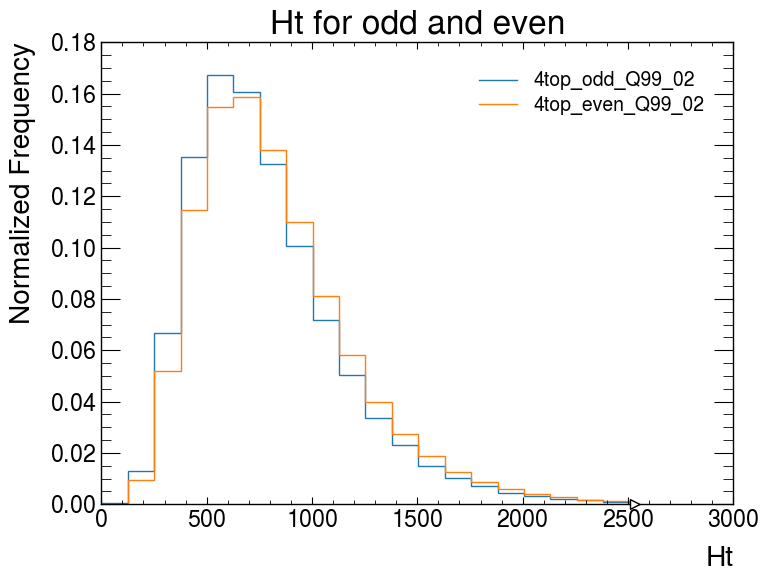

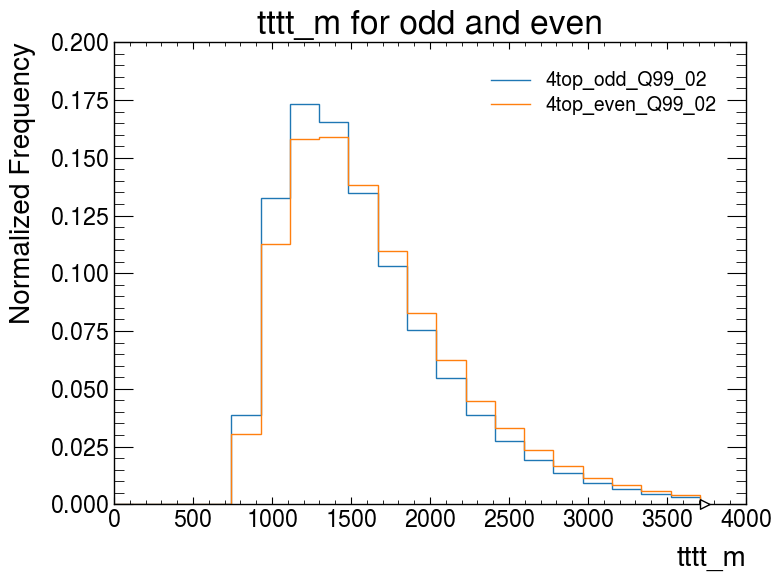

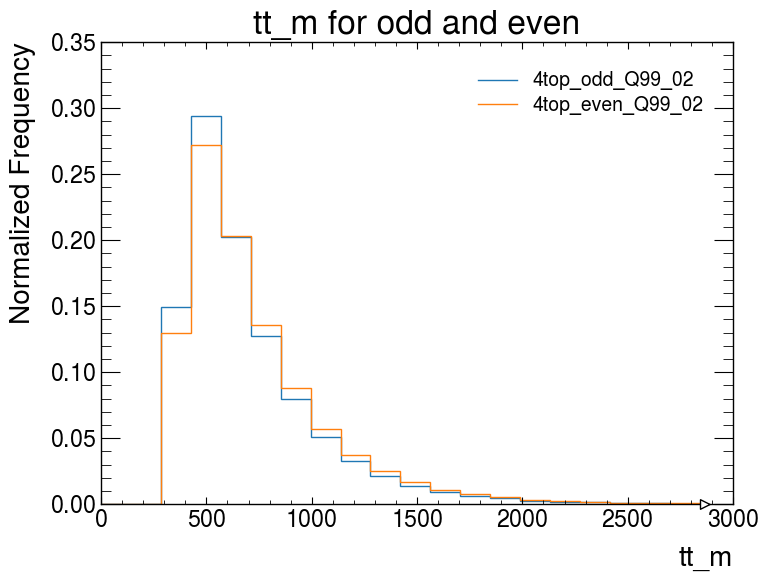

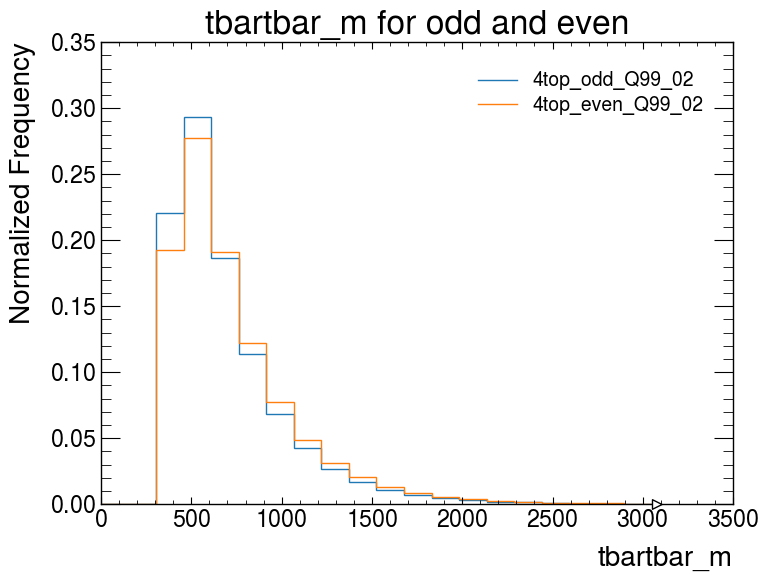

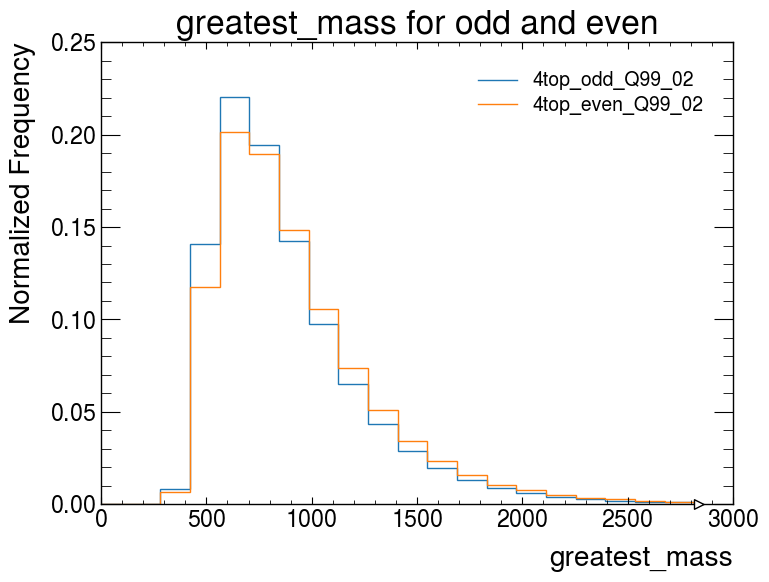

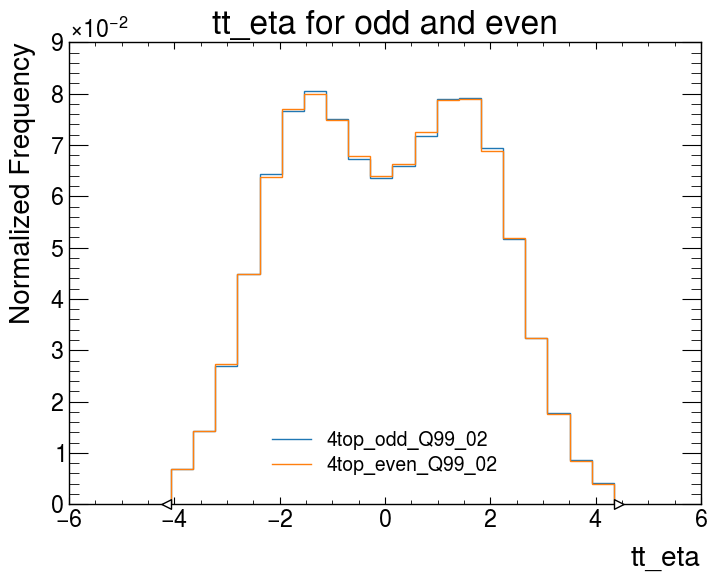

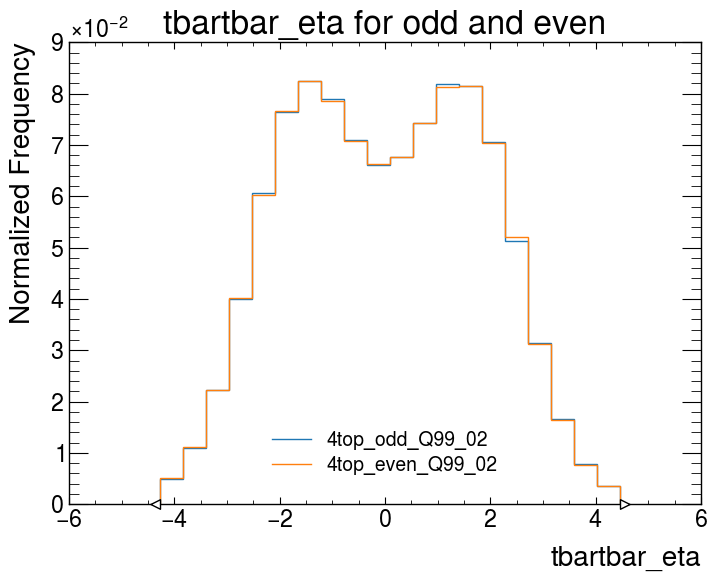

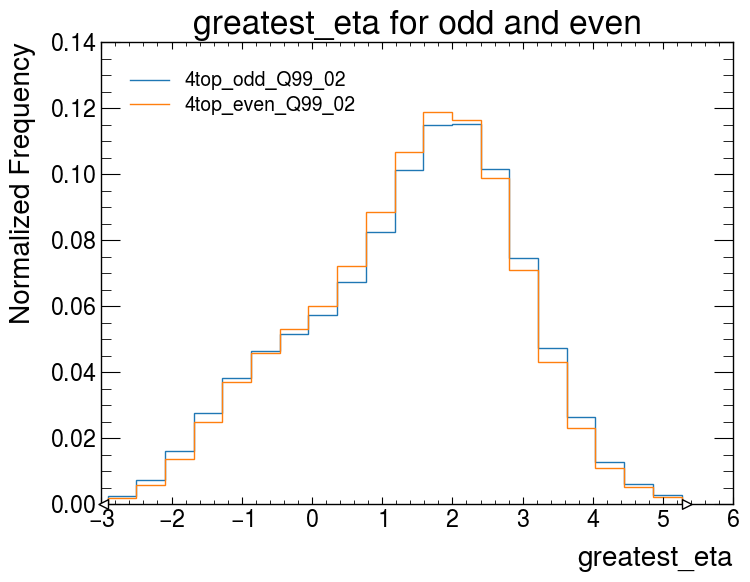

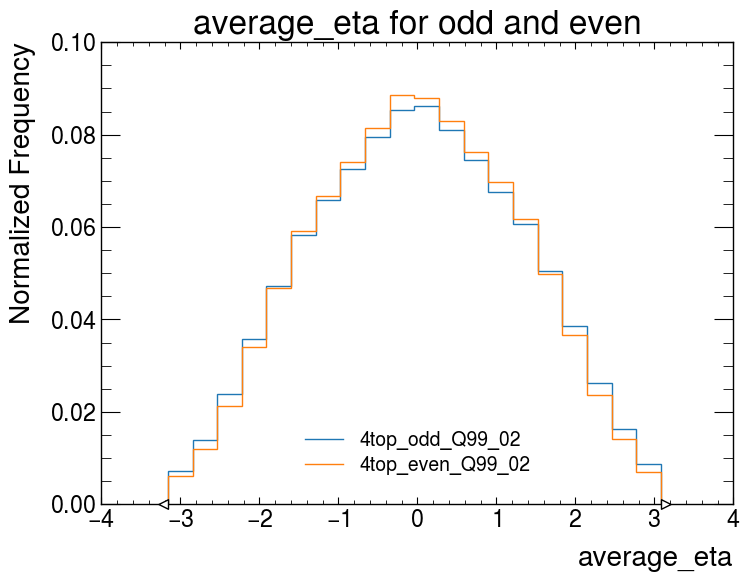

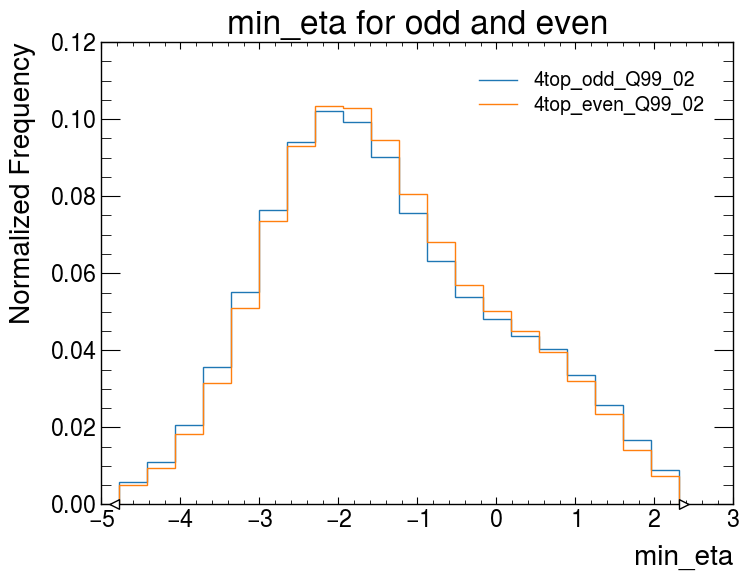

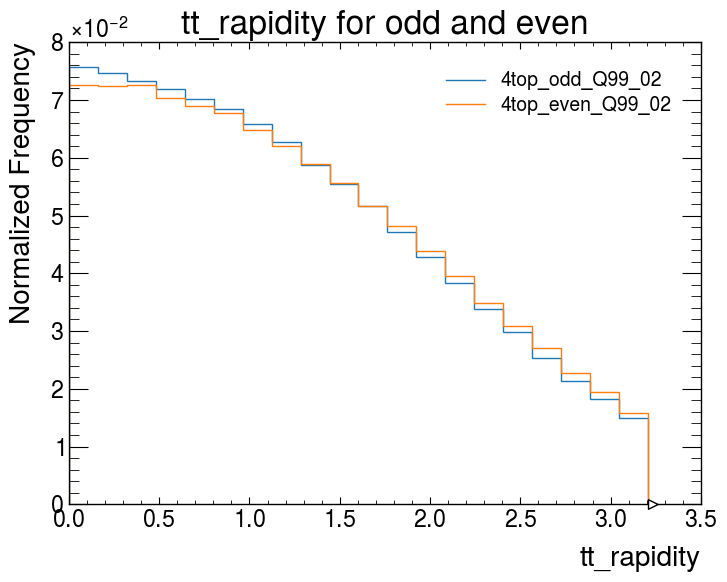

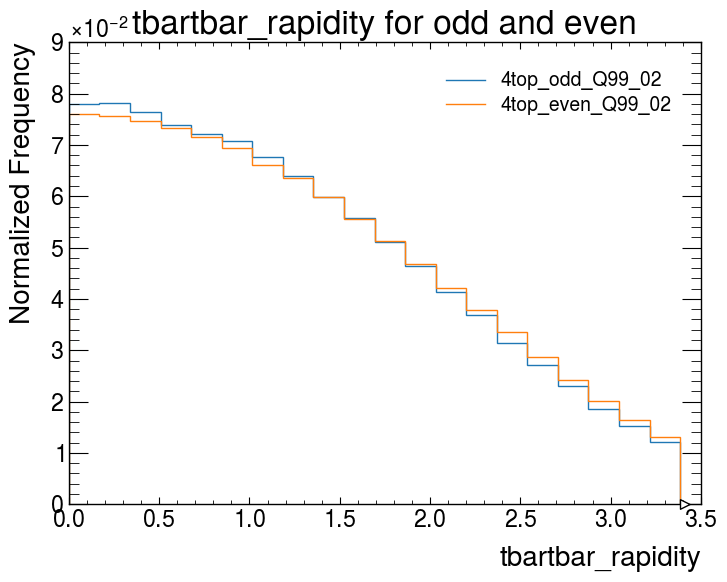

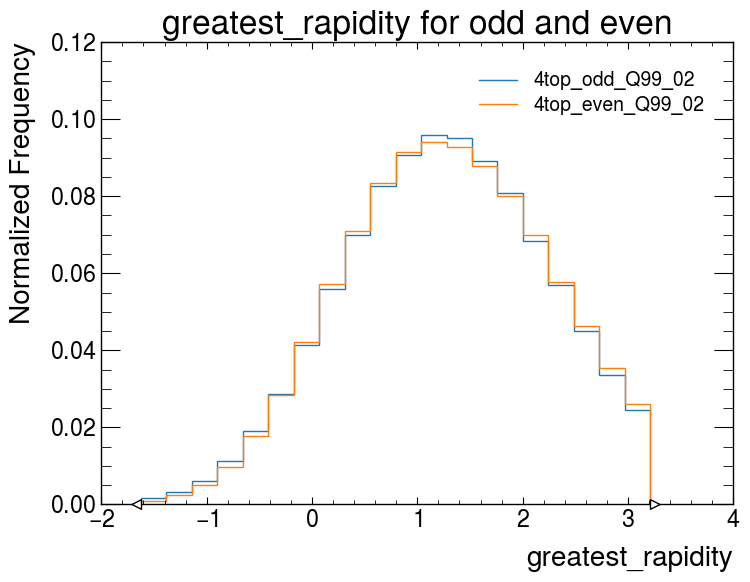

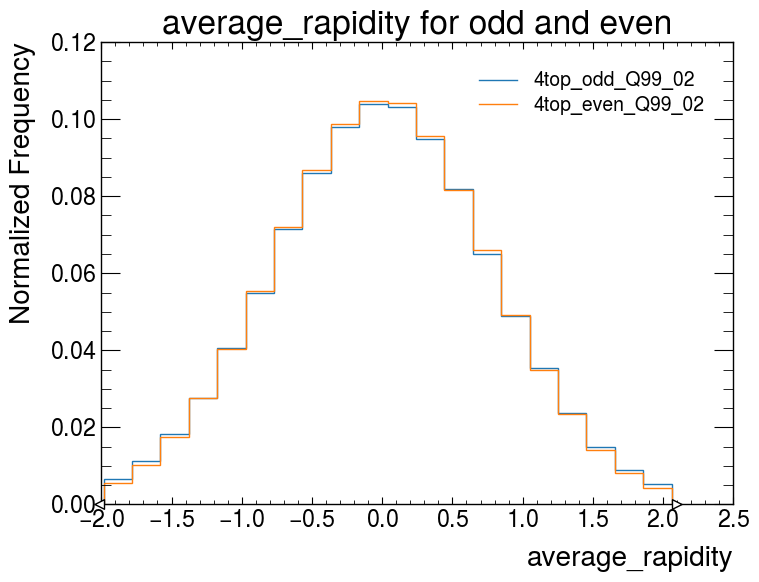

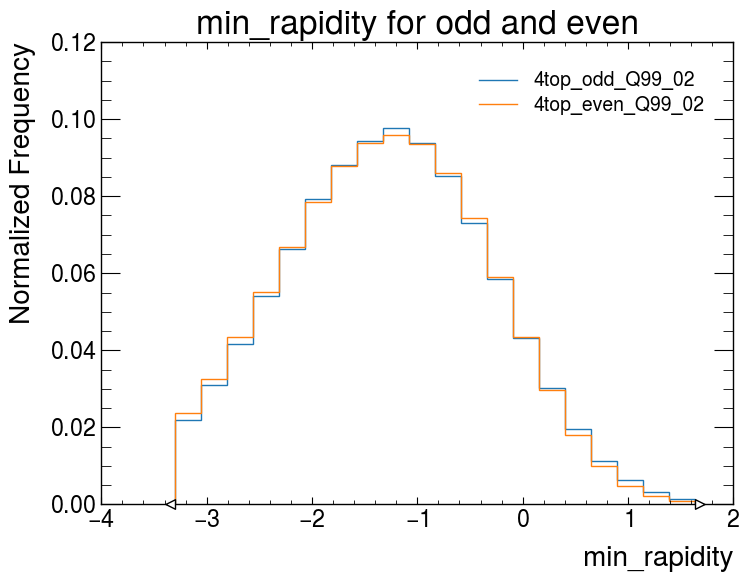

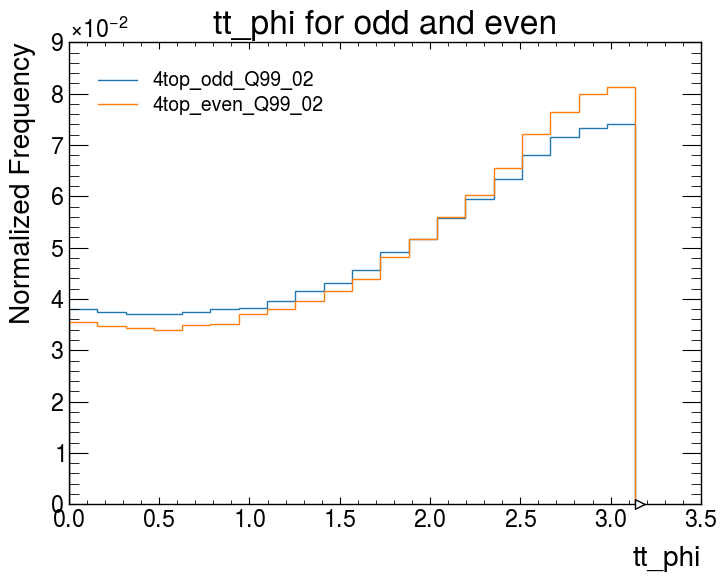

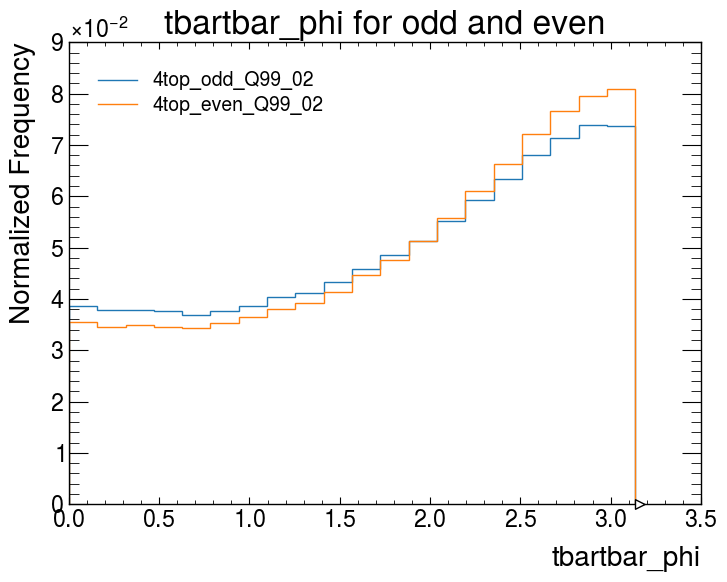

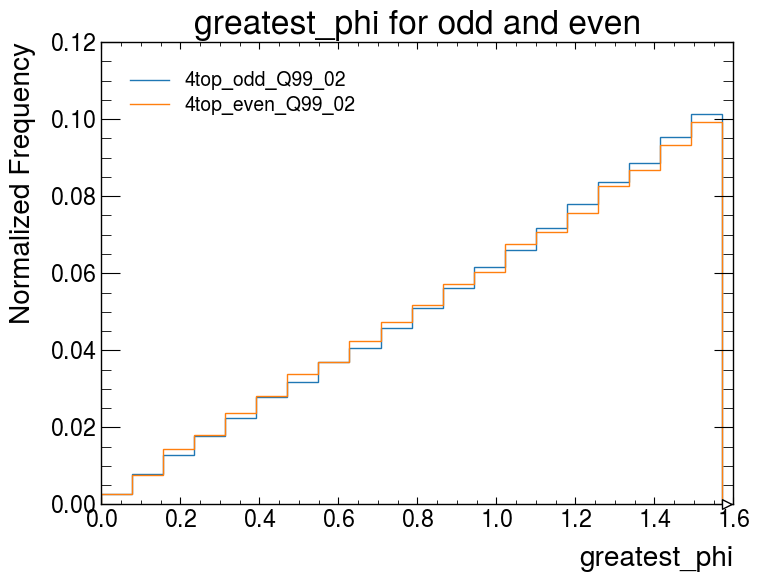

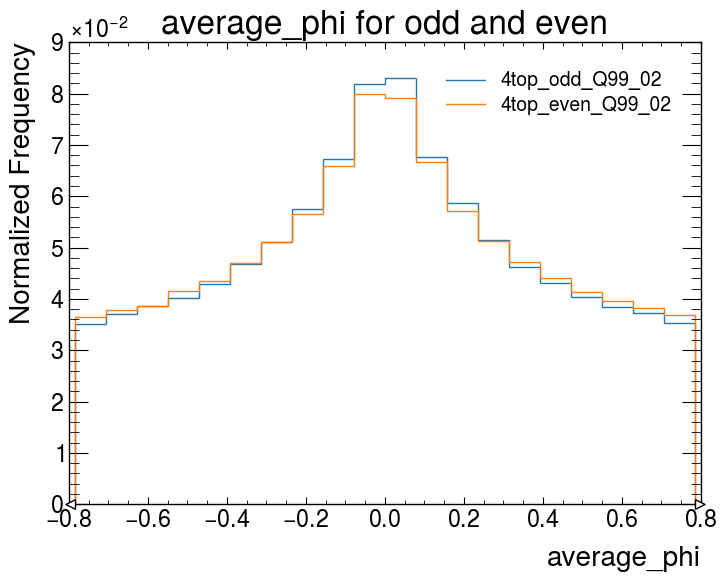

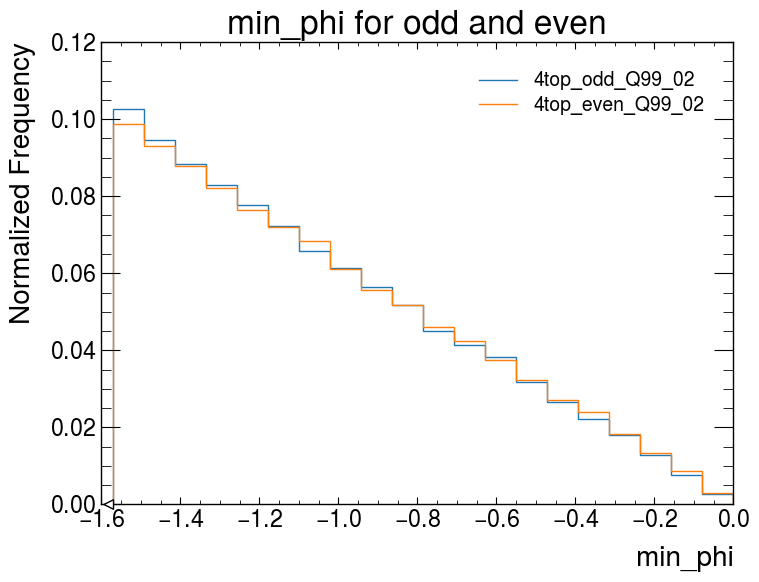

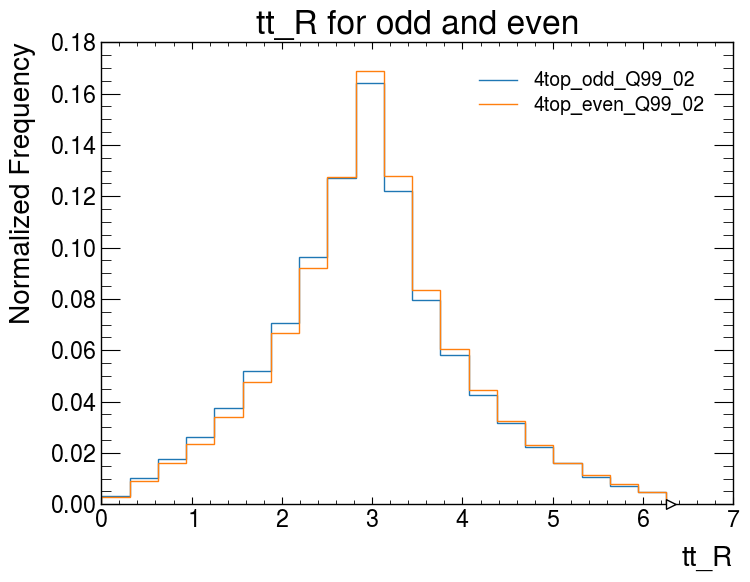

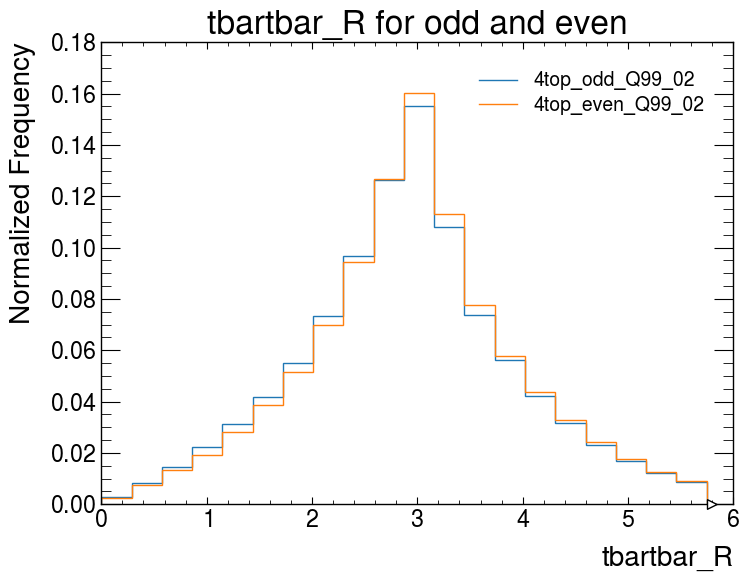

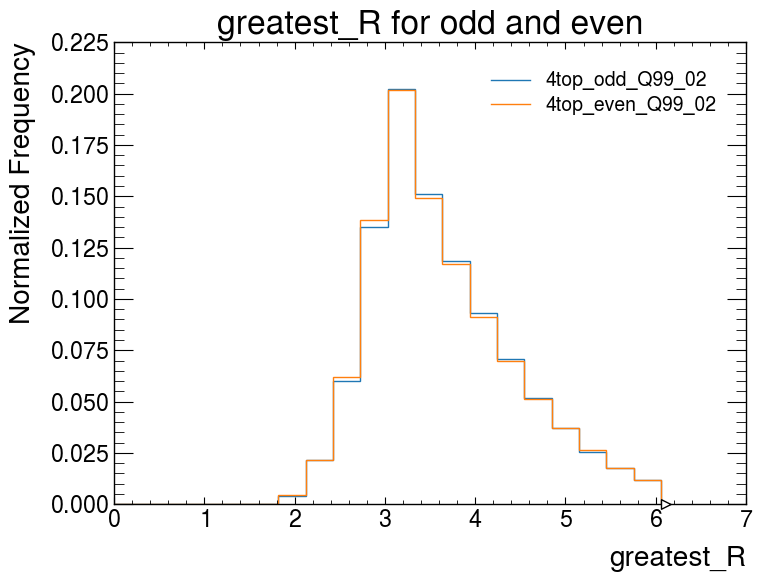

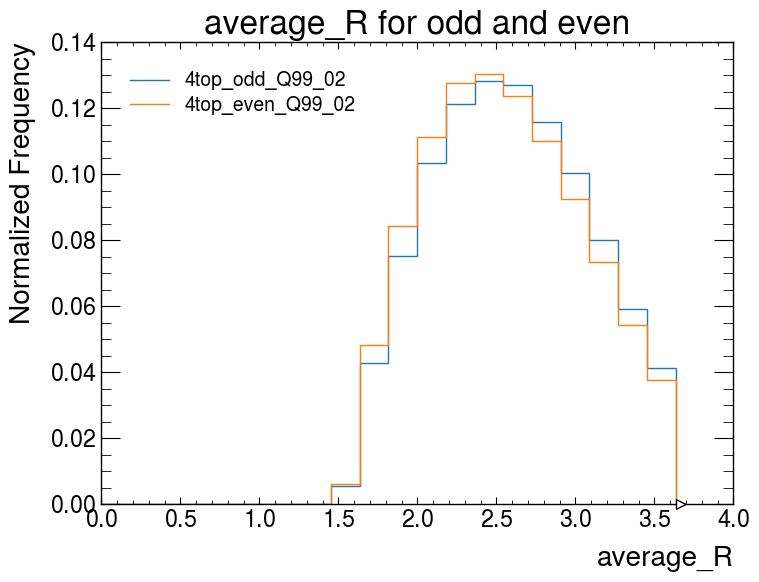

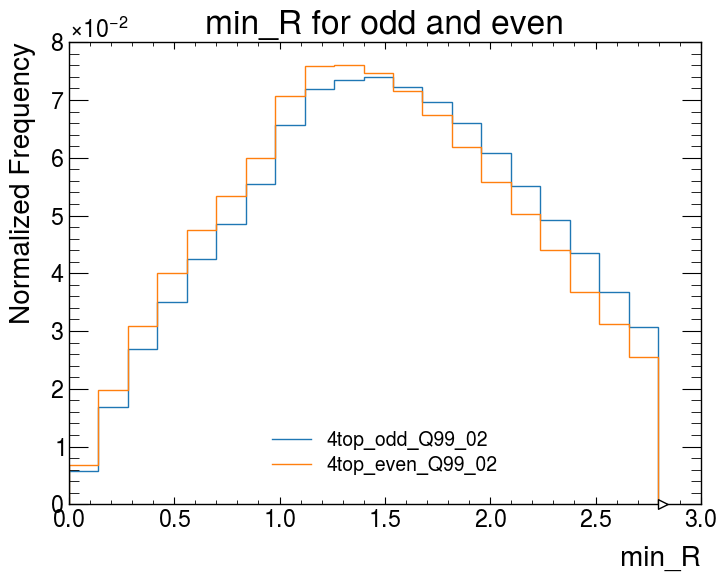

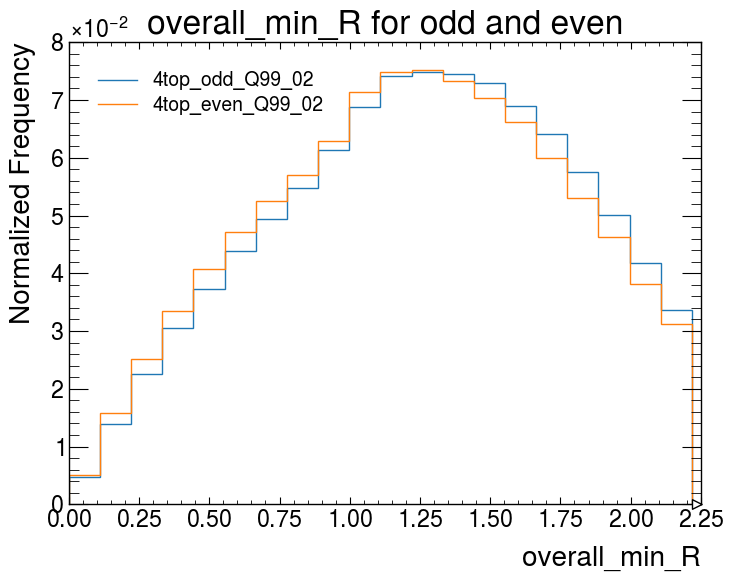

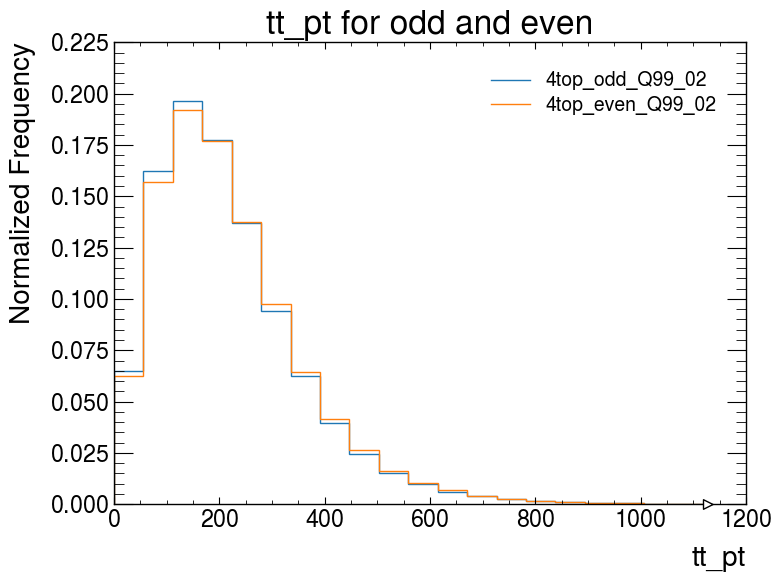

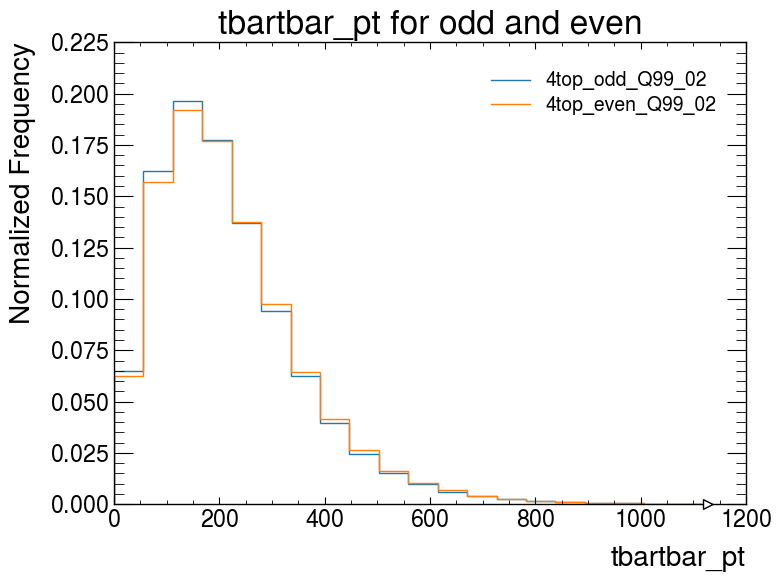

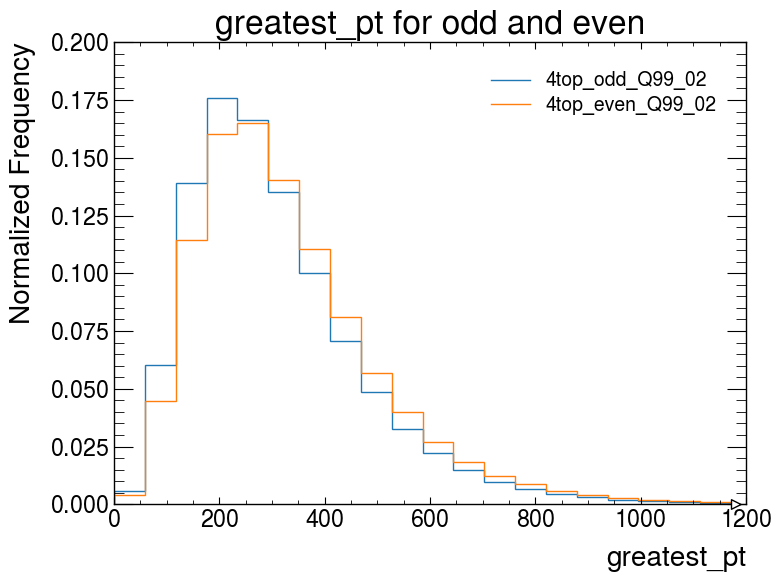

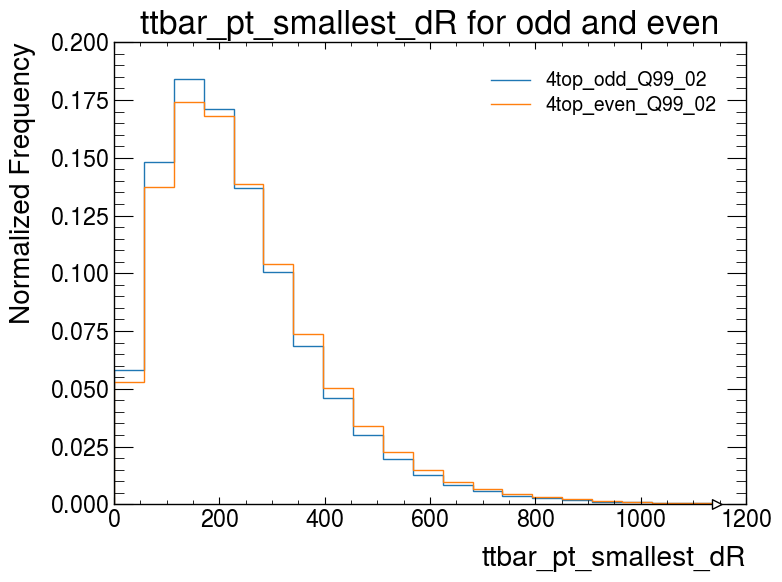

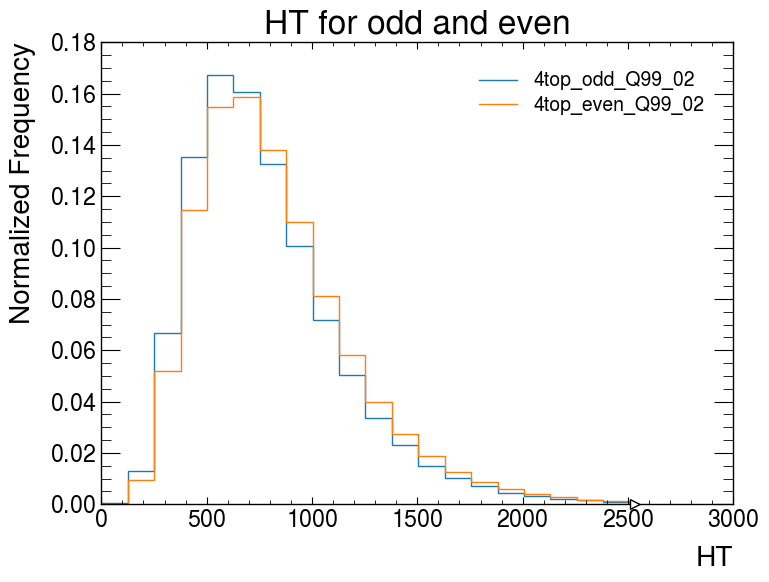

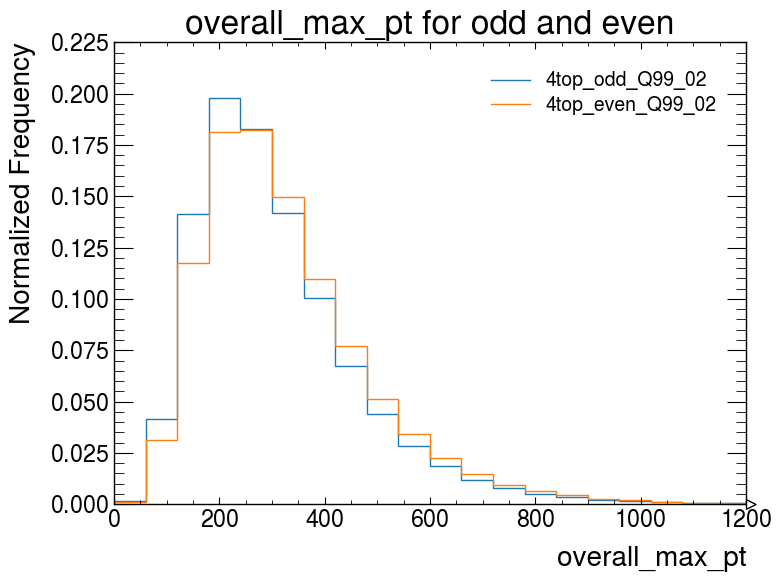

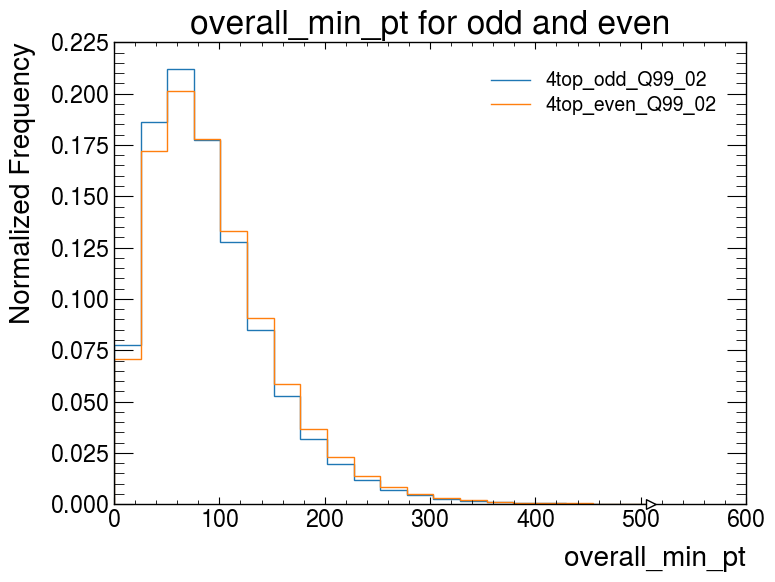

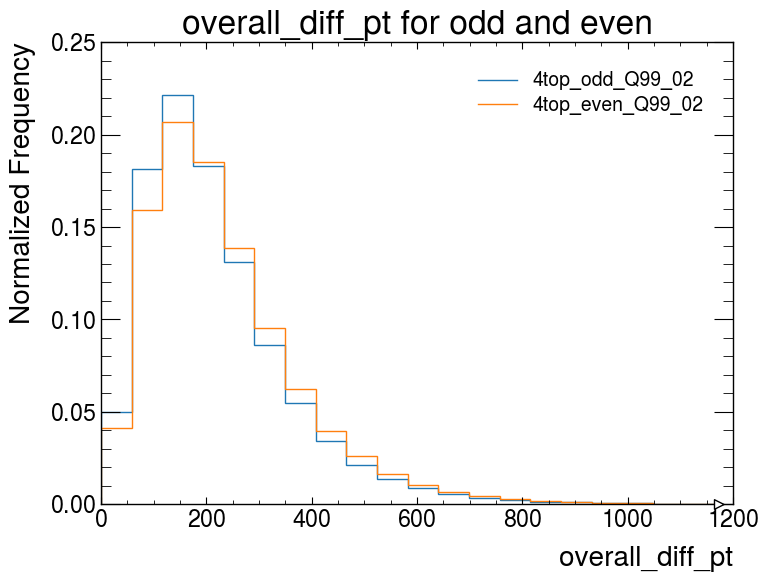

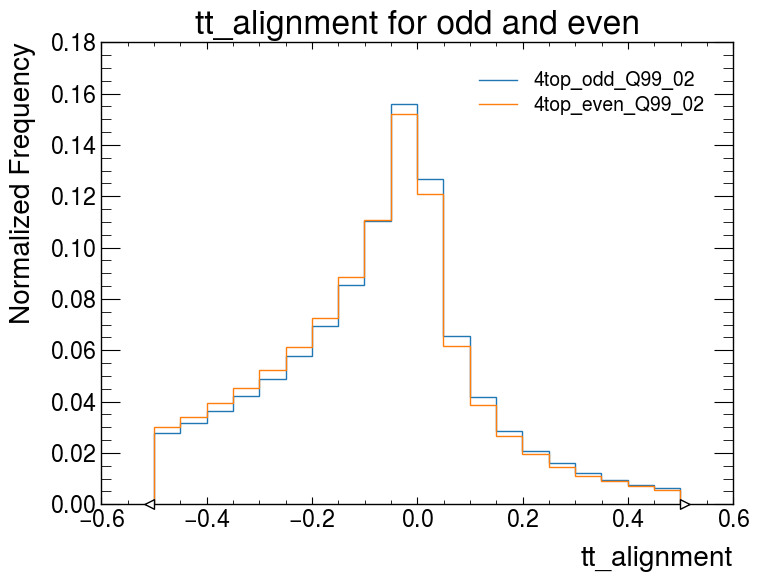

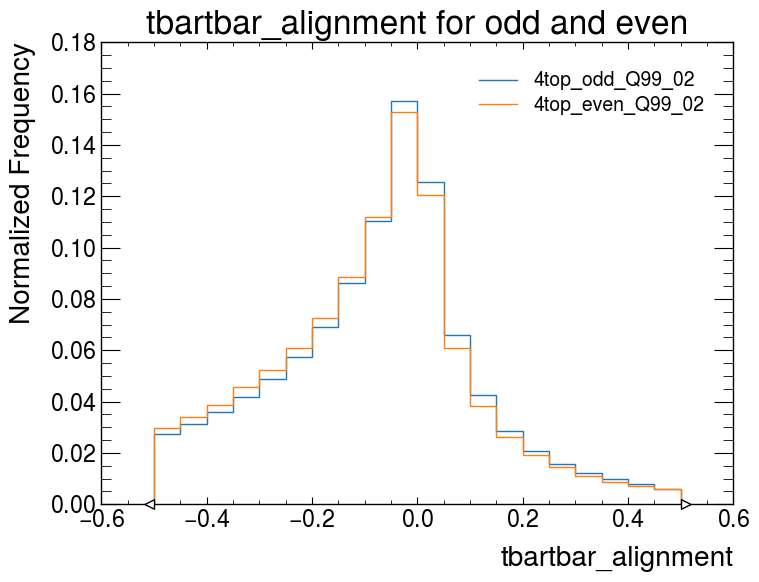

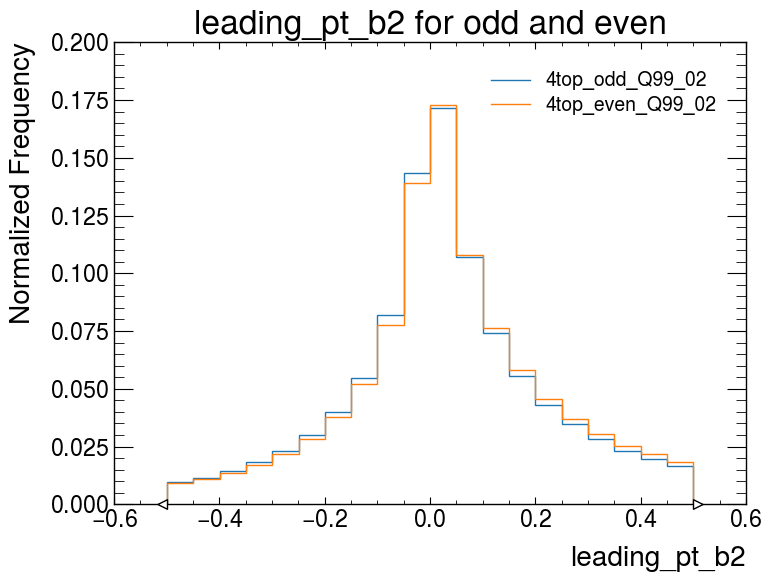

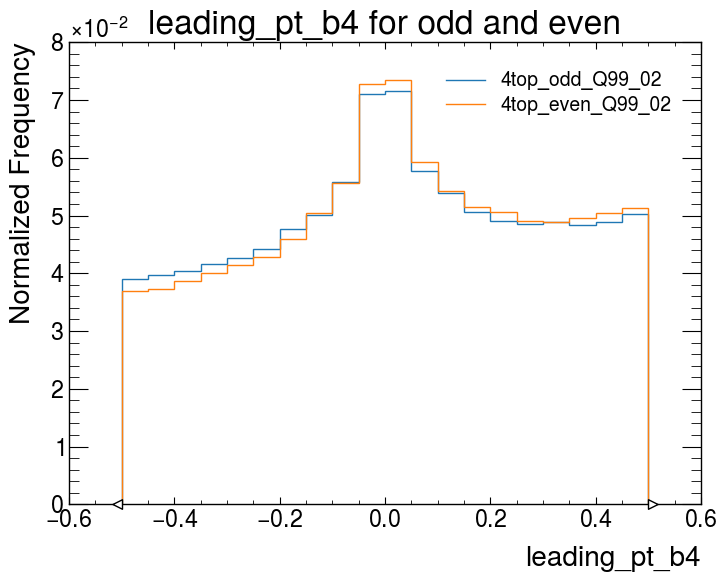

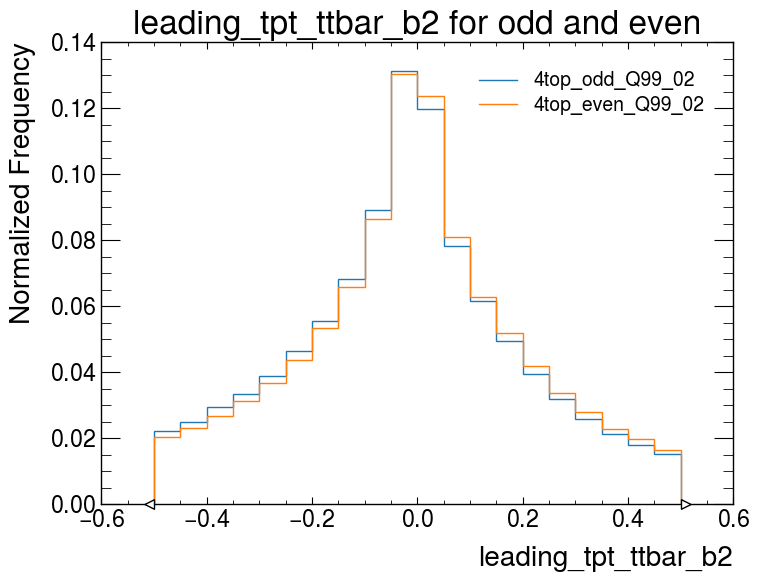

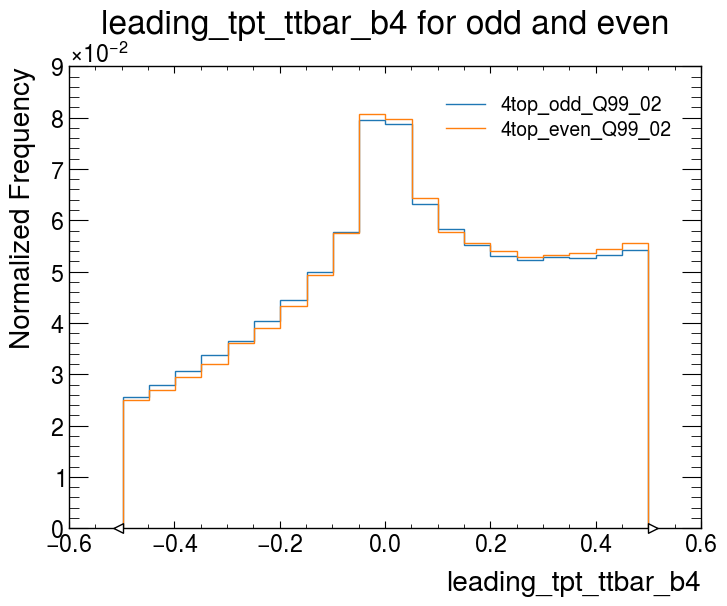

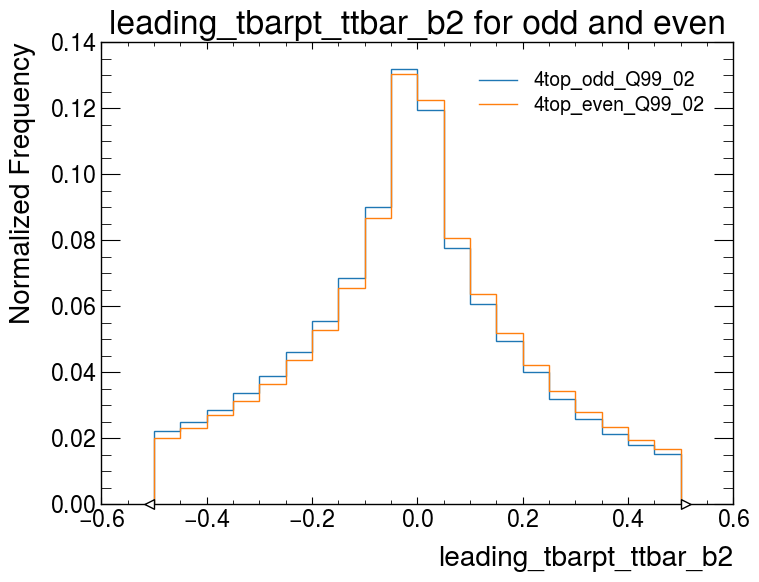

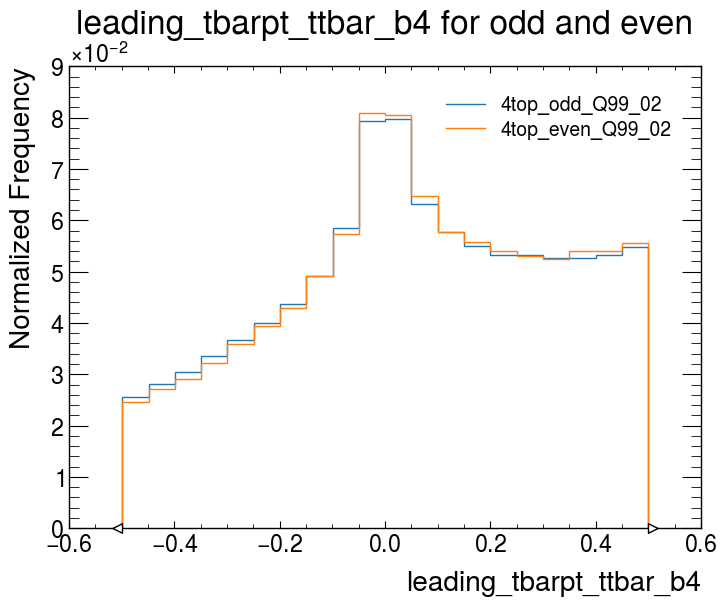

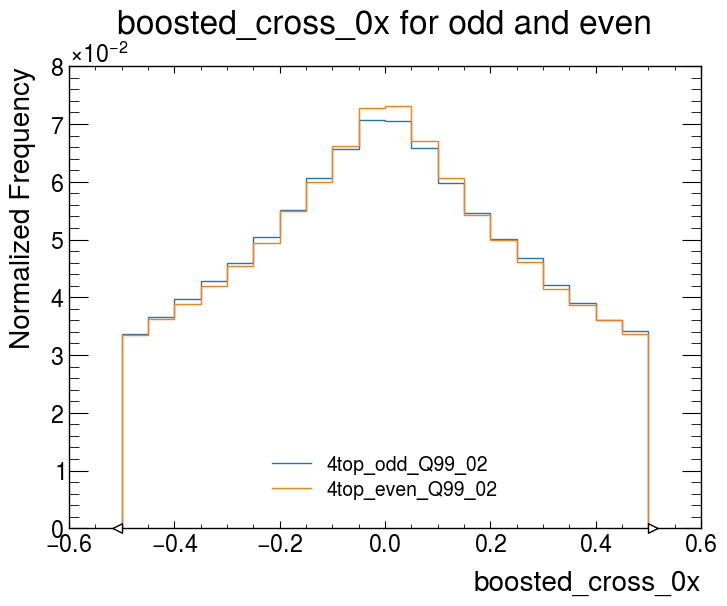

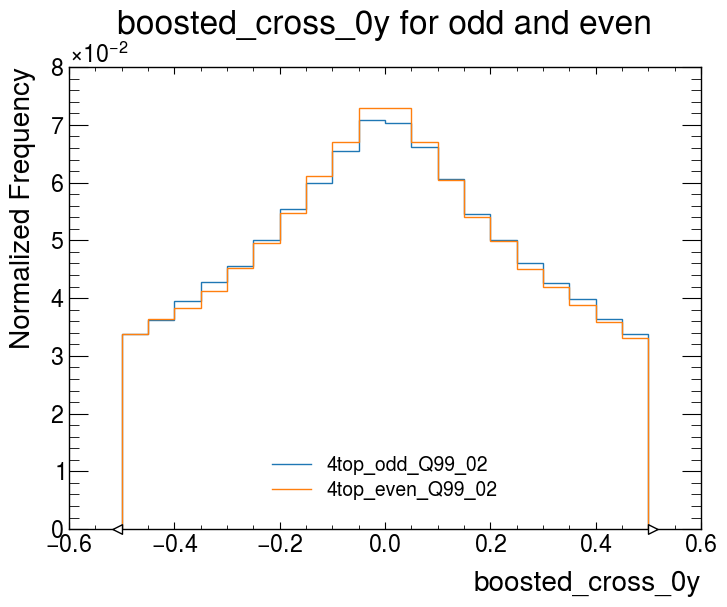

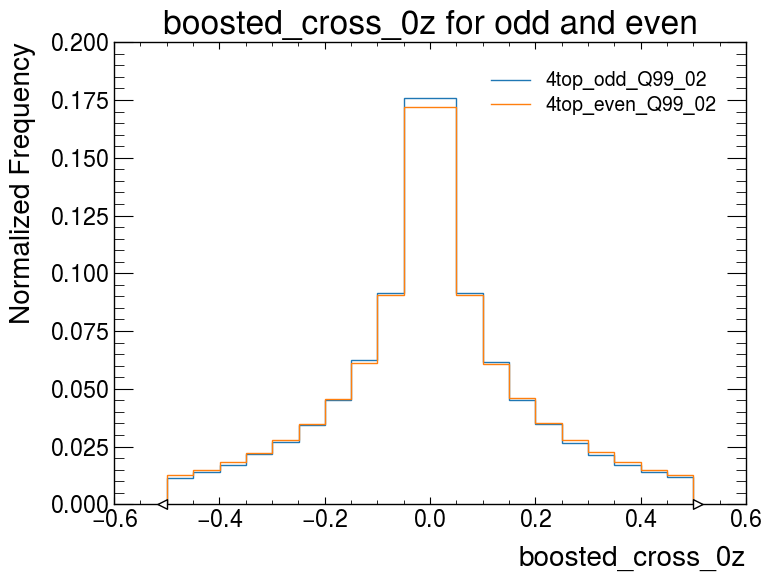

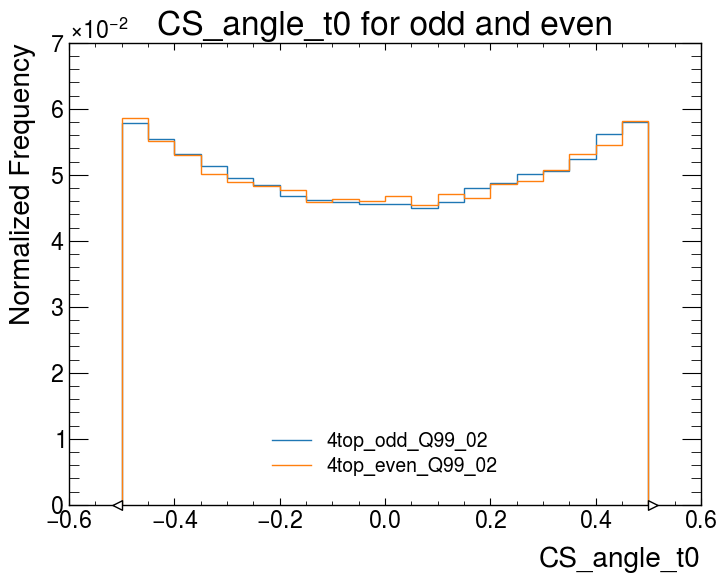

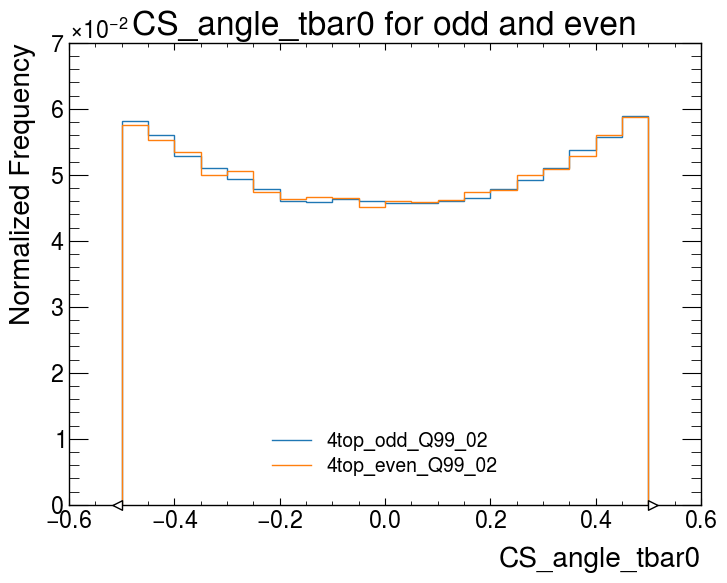

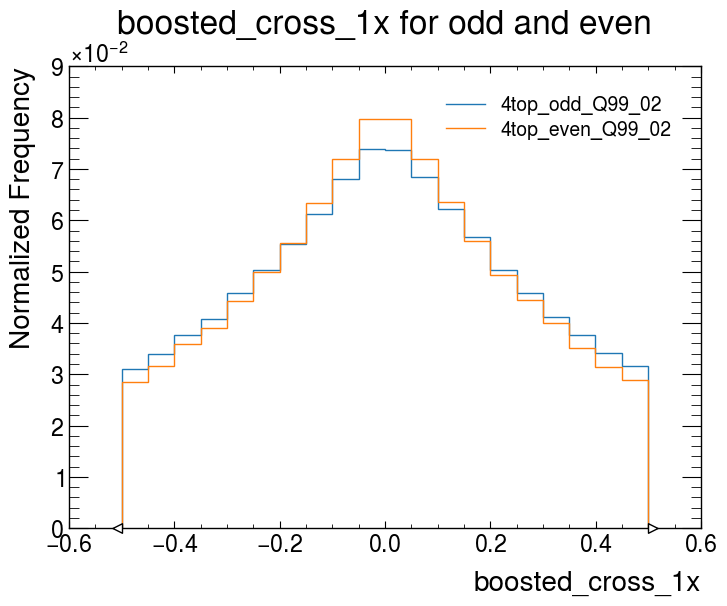

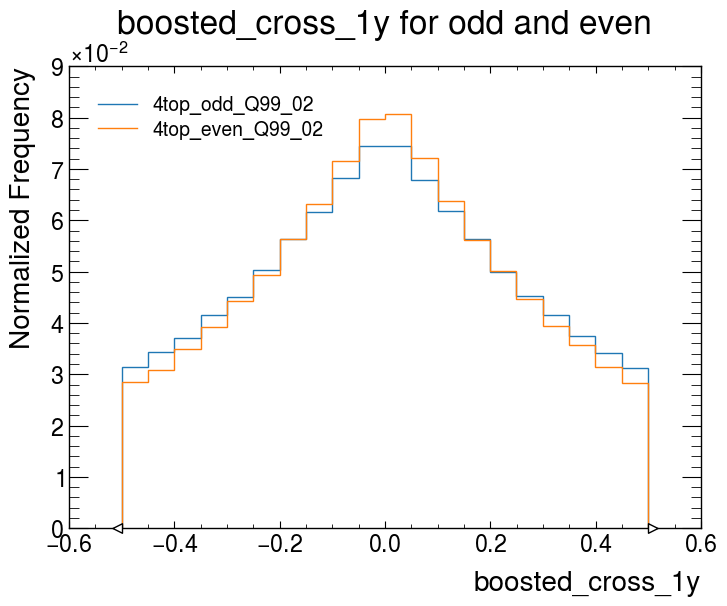

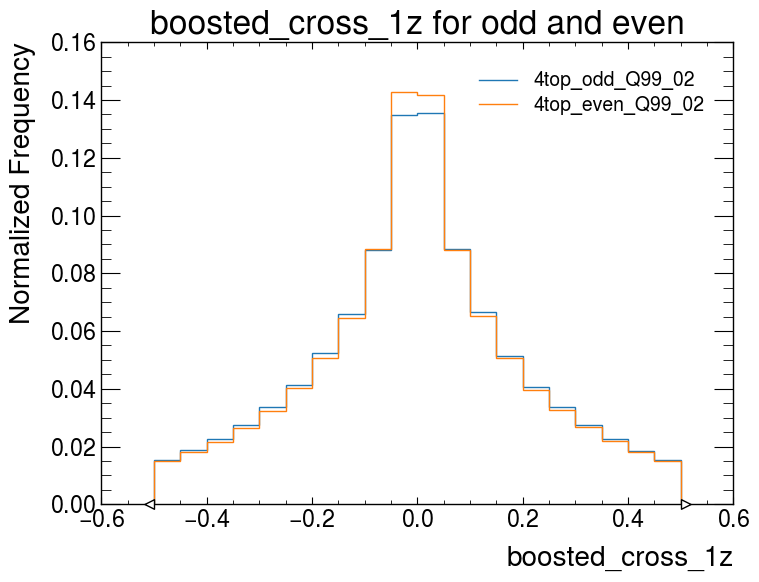

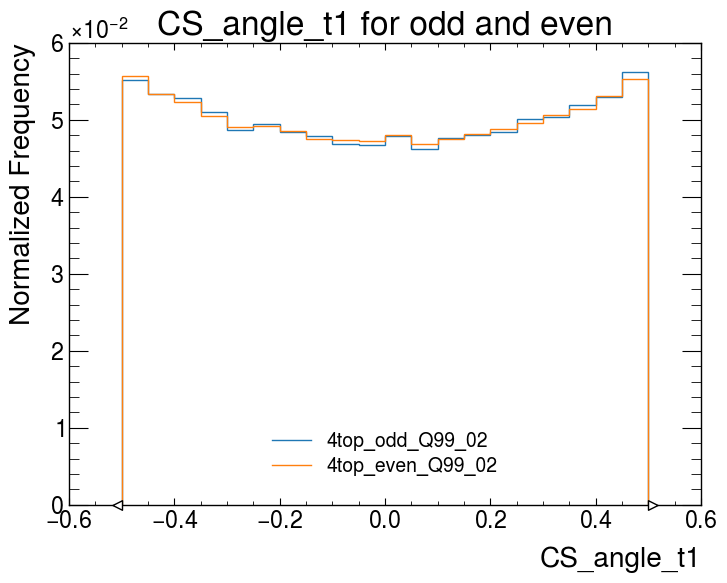

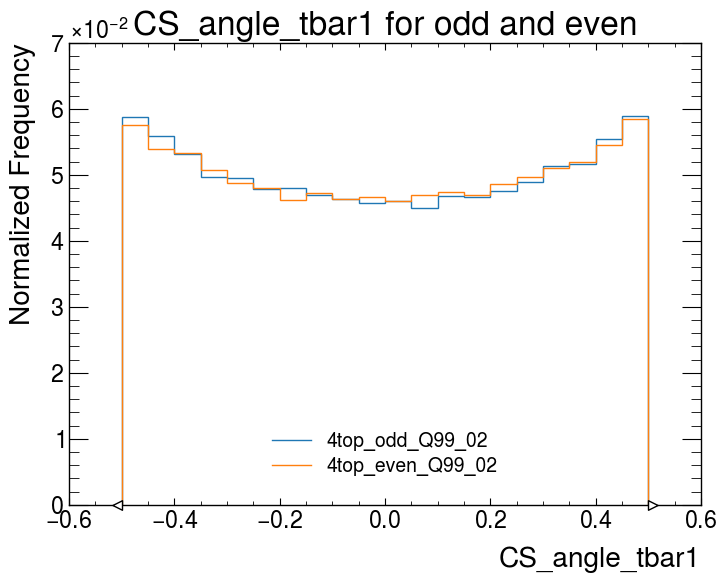

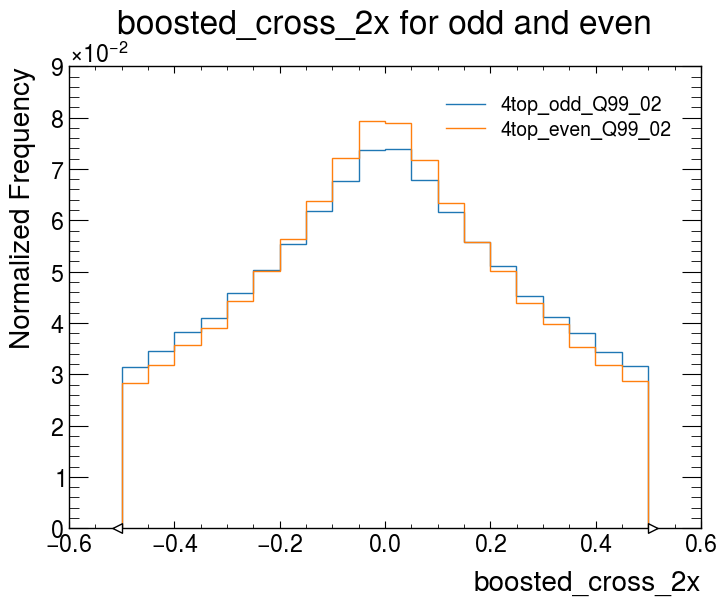

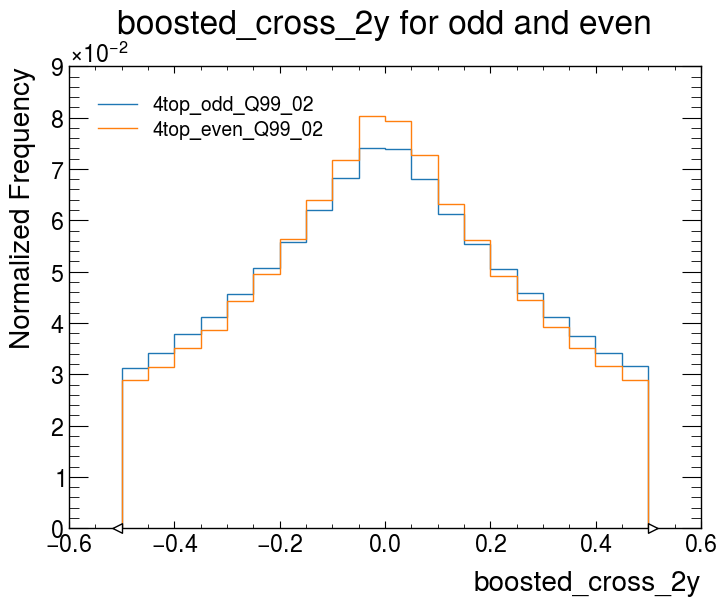

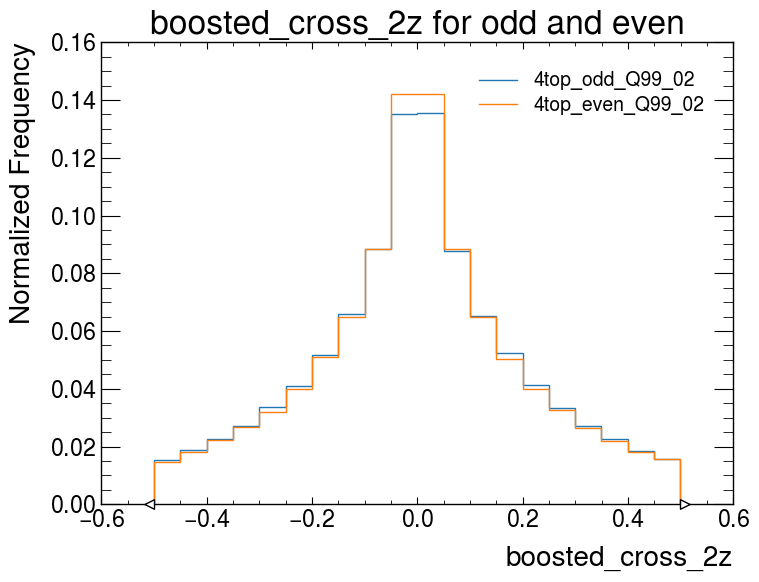

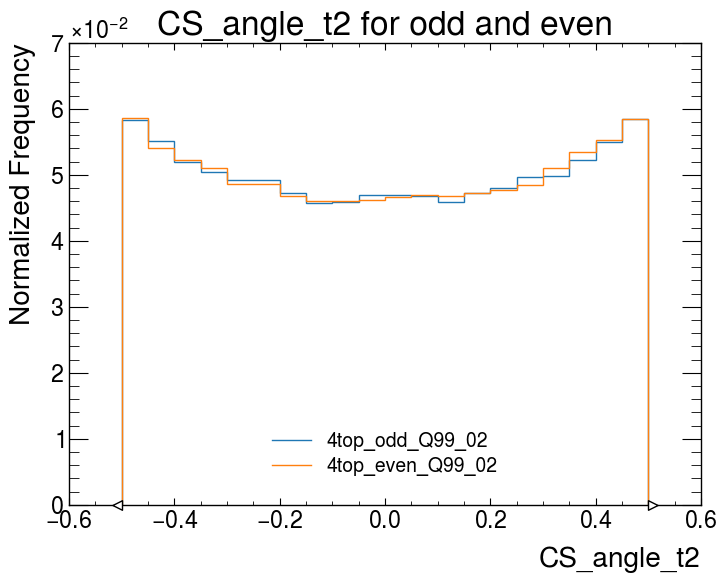

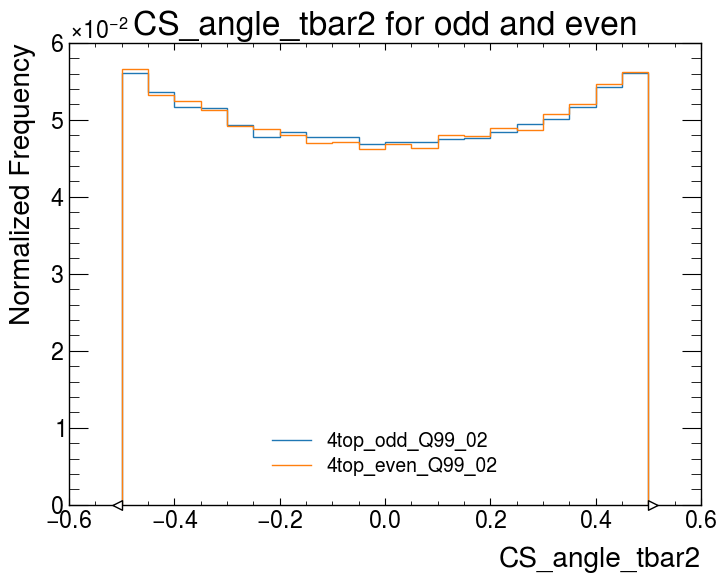

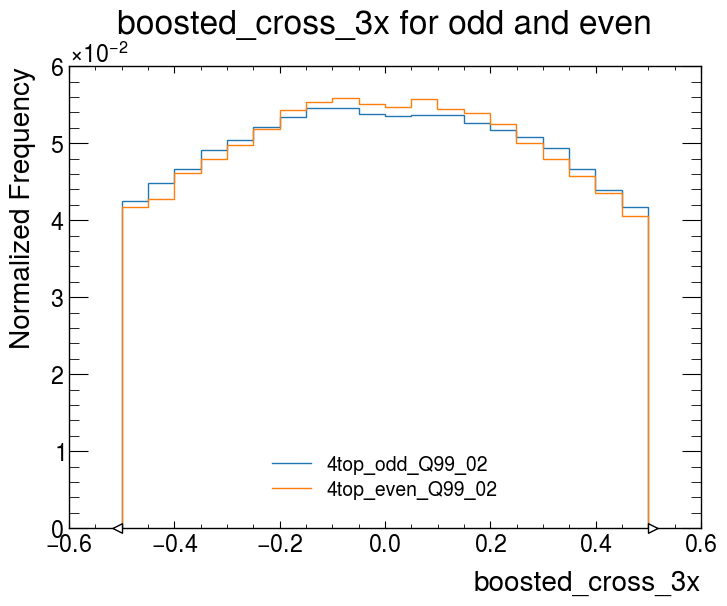

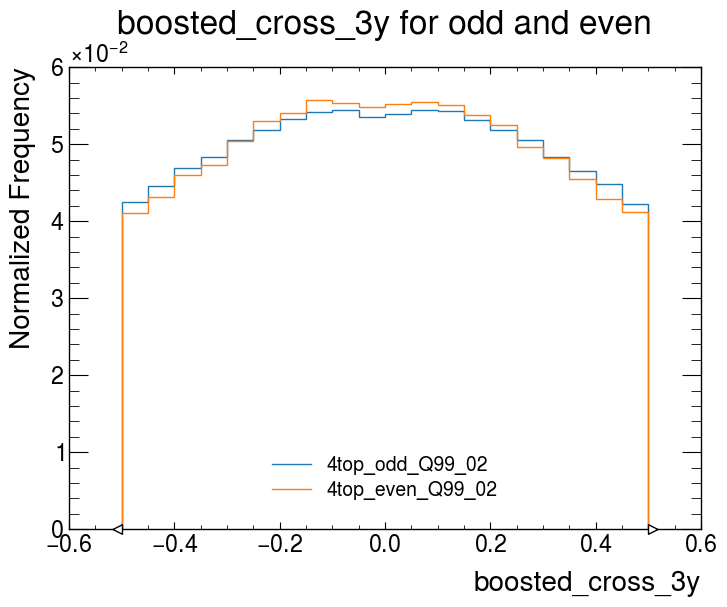

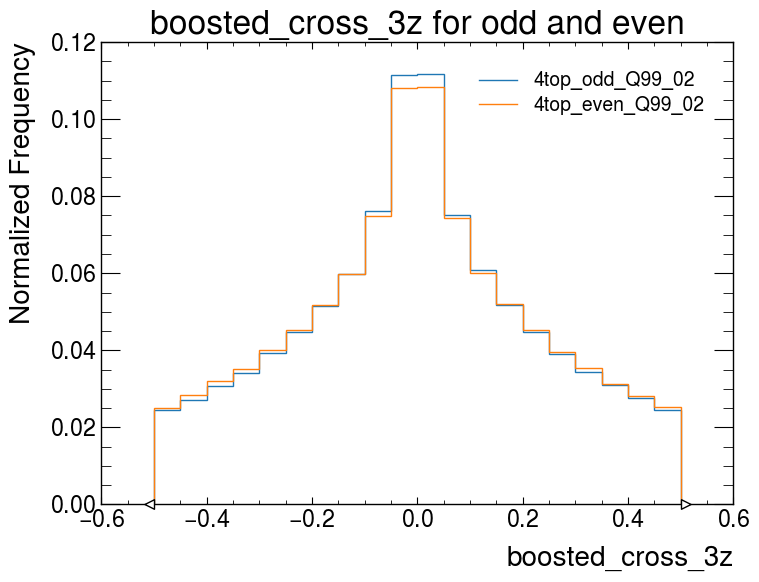

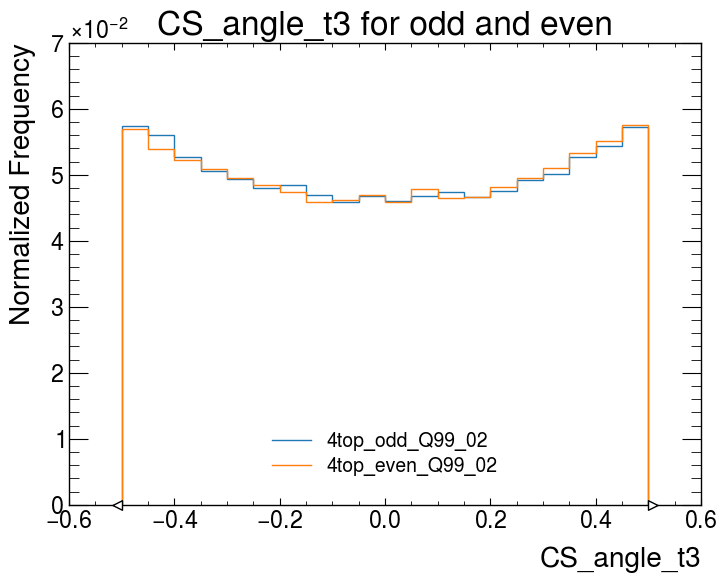

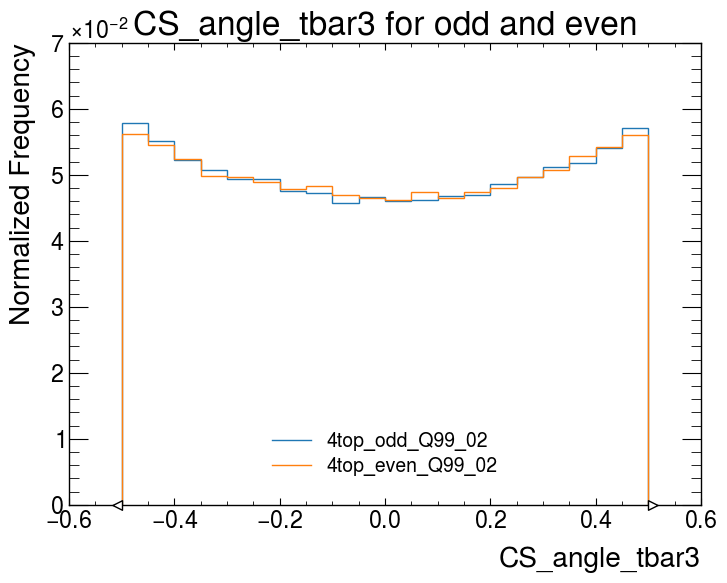

In [12]:
plot_variables(all_data, 20)